<a href="https://colab.research.google.com/github/itsQuassano/Customer-Segmentation/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests_html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3


In [2]:
!pip install yahoo-fin

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.2 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=e38a01c9aa539644dff6087ba77214ba07891e24c57b666e9053f9a85e46f6ac
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [3]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
from yahoo_fin import options
from urllib.request import Request, urlopen
from urllib.error import HTTPError  # Import HTTPError here
from bs4 import BeautifulSoup


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [5]:
website_url = 'https://finviz.com/quote.ashx?t='
company_tickers = ['AMD', 'AMZN', 'FBP', 'GOOG','TFFP']


In [6]:
news_tables = {}
for ticker in company_tickers:
    url = website_url + ticker
    req = Request(url=url, headers={'user-agent': 'my-scrape'})
    try:
        response = urlopen(req)
        html = BeautifulSoup(response, 'html.parser')
        news_data = html.find(id='news-table')
        news_tables[ticker] = news_data
    except HTTPError as e:
        print(f"Error fetching data for {ticker}: {e}")
        news_tables[ticker] = None

In [7]:
import datetime

parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        # Extract the title and date information
        title = row.a.text if row.a else 'No Title'
        date_data = row.td.text.split(' ')

        # Clean the date_data by stripping any unwanted characters and filtering out empty strings
        date_data = [item.strip() for item in date_data if item.strip()]

        # Check if the date_data has at least 2 elements: date and time
        if len(date_data) >= 2:
            try:
                # Extract date and time
                date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
                time = date_data[1][0:7]  # Time (AM/PM)

                # Append the parsed data
                parsed_data.append([ticker, date, time, title])

            except ValueError as e:
                print(f"Error parsing date for {ticker}: {date_data[0]} -> {e}")
        else:
            # Handle the case where there are not enough valid elements in date_data
            print(f"Skipping row for {ticker}, invalid or missing date/time: {date_data}")

# Optionally print out the parsed data to check results
for row in parsed_data:
    print(row)


Skipping row for AMD, invalid or missing date/time: ['02:36PM']
Skipping row for AMD, invalid or missing date/time: ['06:20AM']
Skipping row for AMD, invalid or missing date/time: ['06:08AM']
Skipping row for AMD, invalid or missing date/time: ['06:00AM']
Skipping row for AMD, invalid or missing date/time: ['05:35AM']
Skipping row for AMD, invalid or missing date/time: ['05:35AM']
Skipping row for AMD, invalid or missing date/time: ['04:25AM']
Skipping row for AMD, invalid or missing date/time: ['05:10PM']
Skipping row for AMD, invalid or missing date/time: ['04:15PM']
Skipping row for AMD, invalid or missing date/time: ['01:30PM']
Skipping row for AMD, invalid or missing date/time: ['11:43AM']
Skipping row for AMD, invalid or missing date/time: ['11:12AM']
Skipping row for AMD, invalid or missing date/time: ['08:06AM']
Skipping row for AMD, invalid or missing date/time: ['05:40AM']
Skipping row for AMD, invalid or missing date/time: ['04:40AM']
Skipping row for AMD, invalid or missing

In [8]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,2024/11/20,04:32PM,"Nvidia earnings, forecasts top expectations as..."
1,AMD,2024/11/19,07:33PM,"Advanced Micro Devices, Inc. (AMD): Among Harv..."
2,AMD,2024/11/18,09:33PM,AMD distributor Weikeng eyes 2025 AI boom
3,AMD,2024/11/17,08:27PM,Weekly news roundup: Intel-AMD merger plan fac...
4,AMD,2024/11/16,06:29PM,"Advanced Micro Devices, Inc. (AMD): Eyeing $50..."


In [9]:
sia=SentimentIntensityAnalyzer()

dataset['Compound'] = dataset['News Headline'].apply(lambda headline: sia.polarity_scores(headline)['compound'])

In [10]:
def sentiment_declareation(sentiment_value):
  if -0.2 < sentiment_value <= 0.2:
      return 'neu'
  elif 0.2 < sentiment_value <= 1.0:
      return 'pos'
  elif -1.0 <= sentiment_value <= -0.2:
      return 'neg'

In [11]:
dataset['Sentiment'] = dataset['Compound'].apply(lambda value: sentiment_declareation(value))
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date
dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment
0,AMD,2024-11-20,04:32PM,"Nvidia earnings, forecasts top expectations as...",0.2023,pos
1,AMD,2024-11-19,07:33PM,"Advanced Micro Devices, Inc. (AMD): Among Harv...",0.4215,pos
2,AMD,2024-11-18,09:33PM,AMD distributor Weikeng eyes 2025 AI boom,0.0000,neu
3,AMD,2024-11-17,08:27PM,Weekly news roundup: Intel-AMD merger plan fac...,-0.2960,neg
4,AMD,2024-11-16,06:29PM,"Advanced Micro Devices, Inc. (AMD): Eyeing $50...",0.2500,pos


In [12]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)

In [13]:
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

<ipython-input-13-d93a54dce75b>:1: FutureWarning: The provided callable <function min at 0x78a413818dc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
<ipython-input-13-d93a54dce75b>:1: FutureWarning: The provided callable <function max at 0x78a413818ca0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})


Date            
                min         max
Company                        
AMD      2024-11-04  2024-11-20
AMZN     2024-11-16  2024-11-20
FBP      2022-08-08  2024-10-30
GOOG     2024-11-18  2024-11-20
TFFP     2022-05-11  2024-11-14

In [14]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment,MaxDate,MinDate
0,AMD,2024-11-20,04:32PM,"Nvidia earnings, forecasts top expectations as...",0.2023,pos,2024-11-20,2024-11-04
1,AMD,2024-11-19,07:33PM,"Advanced Micro Devices, Inc. (AMD): Among Harv...",0.4215,pos,2024-11-20,2024-11-04
2,AMD,2024-11-18,09:33PM,AMD distributor Weikeng eyes 2025 AI boom,0.0000,neu,2024-11-20,2024-11-04
3,AMD,2024-11-17,08:27PM,Weekly news roundup: Intel-AMD merger plan fac...,-0.2960,neg,2024-11-20,2024-11-04
4,AMD,2024-11-16,06:29PM,"Advanced Micro Devices, Inc. (AMD): Eyeing $50...",0.2500,pos,2024-11-20,2024-11-04


In [15]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
  if row['Company'] in company_early_late_dates:
      company_early_late_dates[row['Company']]['early'] = row['MinDate']
      company_early_late_dates[row['Company']]['late'] = row['MaxDate']
  else:
    company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2024, 11, 4),
  'late': datetime.date(2024, 11, 20)},
 'AMZN': {'early': datetime.date(2024, 11, 16),
  'late': datetime.date(2024, 11, 20)},
 'FBP': {'early': datetime.date(2022, 8, 8),
  'late': datetime.date(2024, 10, 30)},
 'GOOG': {'early': datetime.date(2024, 11, 18),
  'late': datetime.date(2024, 11, 20)},
 'TFFP': {'early': datetime.date(2022, 5, 11),
  'late': datetime.date(2024, 11, 14)}}

In [16]:
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_NLTK.csv', index=False)

AMD -> {'early': datetime.date(2024, 11, 4), 'late': datetime.date(2024, 11, 20)}
AMZN -> {'early': datetime.date(2024, 11, 16), 'late': datetime.date(2024, 11, 20)}
FBP -> {'early': datetime.date(2022, 8, 8), 'late': datetime.date(2024, 10, 30)}
GOOG -> {'early': datetime.date(2024, 11, 18), 'late': datetime.date(2024, 11, 20)}
TFFP -> {'early': datetime.date(2022, 5, 11), 'late': datetime.date(2024, 11, 14)}


In [17]:
sentiment_result = {}
for value in dataset['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'pos': 65, 'neu': 120, 'neg': 15}

In [18]:
result_by_companies = {}
for index, row in dataset.iterrows():
  if row['Company'] in result_by_companies:
    if row['Sentiment'] == 'neu':
      result_by_companies[row['Company']]['neu'] +=1
    if row['Sentiment'] == 'pos':
      result_by_companies[row['Company']]['pos'] +=1
    if row['Sentiment'] == 'neg':
      result_by_companies[row['Company']]['neg'] +=1
  else:
    result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies


{'AMD': {'neg': 1, 'neu': 5, 'pos': 10},
 'AMZN': {'neg': 0, 'neu': 2, 'pos': 2},
 'FBP': {'neg': 6, 'neu': 53, 'pos': 29},
 'GOOG': {'neg': 0, 'neu': 1, 'pos': 1},
 'TFFP': {'neg': 8, 'neu': 57, 'pos': 20}}

In [19]:
dataframe_list = []
for key, value in result_by_companies.items():
  print(key, '->', value)
  dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 1, 'neu': 5, 'pos': 10}
AMZN -> {'neg': 0, 'neu': 2, 'pos': 2}
FBP -> {'neg': 6, 'neu': 53, 'pos': 29}
GOOG -> {'neg': 0, 'neu': 1, 'pos': 1}
TFFP -> {'neg': 8, 'neu': 57, 'pos': 20}


,Company,Neg,Neu,Pos
0,AMD,1,5,10
1,AMZN,0,2,2
2,FBP,6,53,29
3,GOOG,0,1,1
4,TFFP,8,57,20


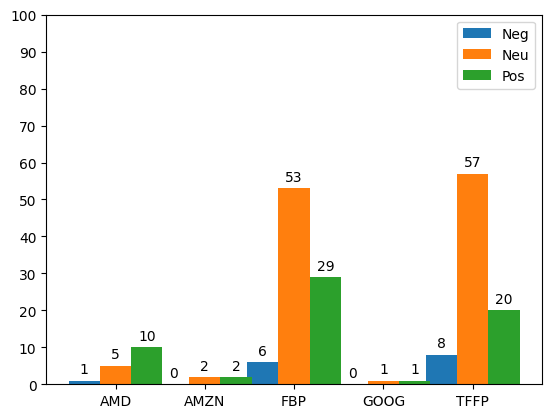

In [20]:
index = np.arange(len(company_tickers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width, dataset_company['Neg'], bar_width, label='Neg')
barNeu = ax.bar(index, dataset_company['Neu'], bar_width, label='Neu')
barPos = ax.bar(index + bar_width, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(company_tickers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
  for bar in bars:
    bar_height = bar.get_height()
    ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barNeu)
insert_data_labels(barPos)

plt.show()

In [21]:
# Perform the groupby on the original dataset, then apply mean() to only numeric columns
mean_df = dataset.groupby(['Company', 'Date']).mean(numeric_only=True)


<Axes: xlabel='Date'>

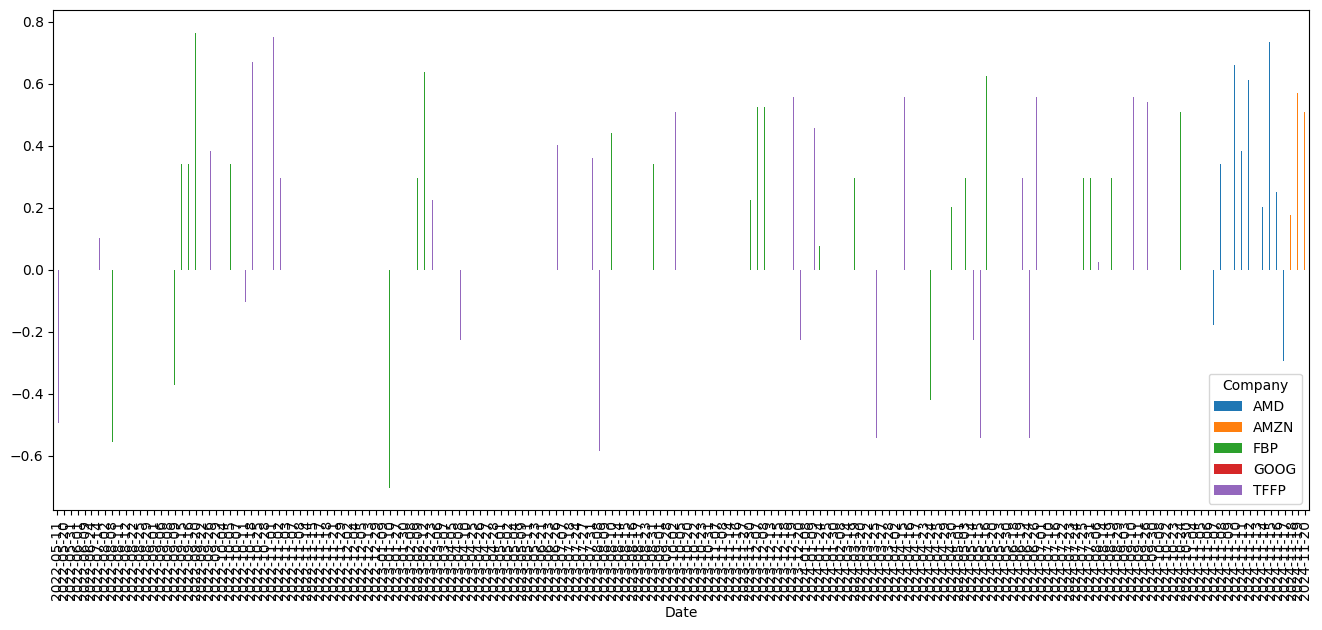

In [22]:
mean_df = mean_df.unstack()
mean_df = mean_df.xs('Compound', axis='columns').transpose()
mean_df.plot(kind='bar', figsize=(16.2, 6.5))

In [23]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')


def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the economic news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

In [24]:
def company_specific_sentiment_visualization(company_name):
    # Ensure 'Company' and 'Date' columns are in the dataset
    if 'Company' not in dataset.columns or 'Date' not in dataset.columns:
        print("The dataset does not contain 'Company' or 'Date' columns.")
        return

    # Filter the dataset for the specific company
    company_df = dataset[dataset['Company'] == company_name]

    # Ensure that 'Date' column is in datetime format if it exists
    if company_df['Date'].dtype == 'object':
        try:
            company_df['Date'] = pd.to_datetime(company_df['Date'])
        except Exception as e:
            print(f"Error converting 'Date' to datetime format: {e}")
            return

    # Sort by date
    company_df = company_df.sort_values('Date')

    # Select numeric data only
    numeric_df = company_df.select_dtypes(include='number')

    # Check if the 'Compound' column exists in numeric data
    if 'Compound' not in numeric_df.columns:
        print("The 'Compound' column is missing in the filtered dataset.")
        return

    # Perform groupby and calculate mean
    temp = numeric_df.groupby(company_df['Date']).mean()

    # Plot the Compound sentiment over time if available
    if 'Compound' in temp.columns:
        temp['Compound'].plot(kind='line', figsize=(16.2, 6.5), title=f"Sentiment Trend for {company_name}")
        plt.xlabel("Date")
        plt.ylabel("Compound Sentiment Score")
        plt.show()
    else:
        print("No 'Compound' data available to plot.")

# Call the function for the specified company
def company_specific_sentiment_and_stockclose_day_focus_visualization(company_name, company_stock_dataframe):
    # Filter dataset for the specific company
    company_specific = dataset[dataset['Company'] == company_name]

    # Select only numeric columns and calculate the mean
    numeric_cols = company_specific.select_dtypes(include='number').columns
    temp_company = company_specific.groupby(['Company', 'Date'])[numeric_cols].mean().reset_index()

    # Save to CSV
    csv_filename = f"{company_name}_SentimentAndValueOnDays.csv"
    temp_company.to_csv(csv_filename, index=False)

    # Load the saved CSV and map adjusted close prices from stock data
    temp_dataframe = pd.read_csv(csv_filename)

    # Ensure 'Date' in both dataframes is in datetime format for accurate merging
    temp_dataframe['Date'] = pd.to_datetime(temp_dataframe['Date'], errors='coerce')
    company_stock_dataframe['date'] = pd.to_datetime(company_stock_dataframe['date'], errors='coerce')

    # Map the 'adjclose' stock values to the sentiment data based on 'Date'
    temp_dataframe['adjclose'] = temp_dataframe['Date'].map(company_stock_dataframe.set_index('date')['adjclose'].to_dict())

    # Drop rows where 'adjclose' is NaN due to unmatched dates
    temp_dataframe = temp_dataframe.dropna(subset=['adjclose'])

    return temp_dataframe


def company_compound_adjclose_normalized(company_name, company_combinated_dataframe):
    # Exclude non-numeric columns like 'Date' and 'Company' from the normalization
    numeric_columns = company_combinated_dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Normalize the numeric columns
    normalized_df = (company_combinated_dataframe[numeric_columns] - company_combinated_dataframe[numeric_columns].mean()) / company_combinated_dataframe[numeric_columns].std()

    # Add 'Date' back to the dataframe for plotting
    normalized_df['Date'] = company_combinated_dataframe['Date']

    # Plot the normalized values
    plt.figure(figsize=(16.2, 6.5))
    plt.title(company_name + ': Normalized AdjClose values with Compounds')
    plt.plot(normalized_df['Date'], normalized_df['Compound'], label='Compound')
    plt.plot(normalized_df['Date'], normalized_df['adjclose'], label='AdjClose')
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.show()


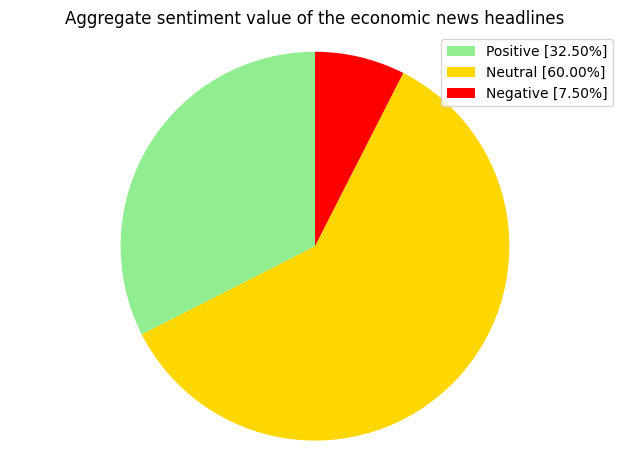

In [25]:
all_num = sentiment_result['pos'] + sentiment_result['neu'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neu_percent = percentage(part=sentiment_result['neu'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=neu_percent, negative=neg_percent)

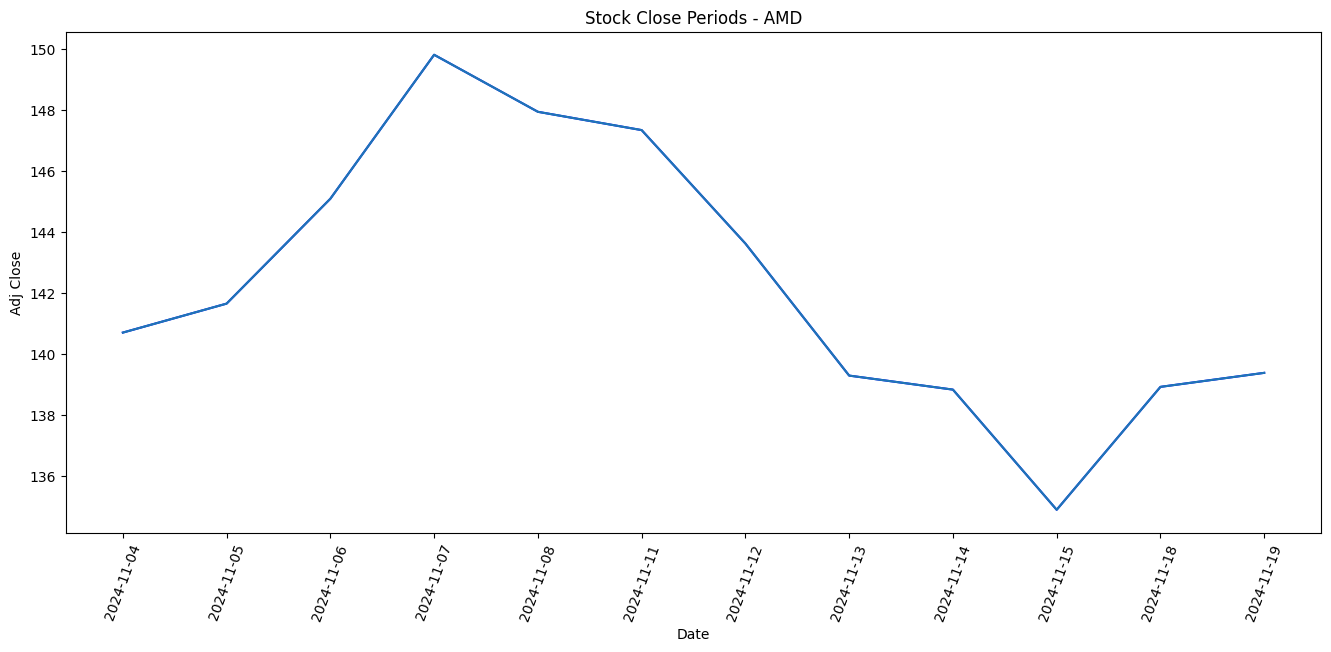

In [26]:
amd_stock = pd.read_csv("/content/AMD_NLTK.csv")
amzn_stock = pd.read_csv("/content/AMZN_NLTK.csv")
fb_stock = pd.read_csv("/content/FBP_NLTK.csv")
goog_stock = pd.read_csv("/content/GOOG_NLTK.csv")


def company_corr(company_stock, company_combinated_dataframe):
  company_data = company_combinated_dataframe.merge(company_stock, on='adjclose')
  company_data.drop(['ticker', 'date'], axis=1, inplace=True)
  company_data.rename(columns = {'Compound_x':'Compound'}, inplace = True)

  plt.figure(figsize=(16, 10))
  sns.heatmap(company_data[['open', 'low', 'high', 'adjclose', 'Compound']].corr(), annot=True)
  plt.show()


plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMD')
plt.plot(amd_stock['adjclose'], label='AMD', color = 'blue')
x = amd_stock['date']
y = amd_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

In [28]:
# Select only numeric columns from the DataFrame
numeric_columns = amd_stock.select_dtypes(include=['number'])

# Now calculate the correlation
correlation_matrix = numeric_columns.corr()

# Display the correlation matrix
print(correlation_matrix)


              open      high       low     close  adjclose    volume
open      1.000000  0.977593  0.939795  0.900005  0.900005 -0.335719
high      0.977593  1.000000  0.967501  0.944575  0.944575 -0.381101
low       0.939795  0.967501  1.000000  0.962374  0.962374 -0.514029
close     0.900005  0.944575  0.962374  1.000000  1.000000 -0.475121
adjclose  0.900005  0.944575  0.962374  1.000000  1.000000 -0.475121
volume   -0.335719 -0.381101 -0.514029 -0.475121 -0.475121  1.000000


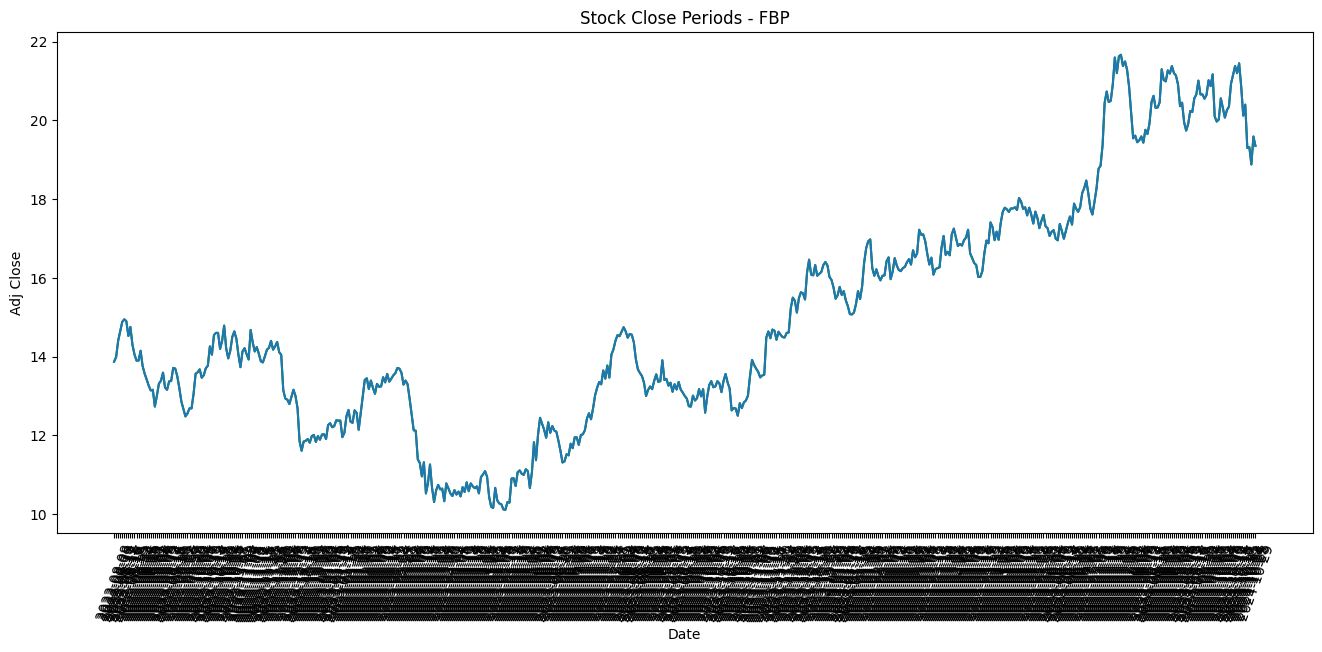

In [29]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - FBP')
plt.plot(fb_stock['adjclose'], label='FBP', color = 'green')
x = fb_stock['date']
y = fb_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

<ipython-input-24-290457988811>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df['Date'] = pd.to_datetime(company_df['Date'])


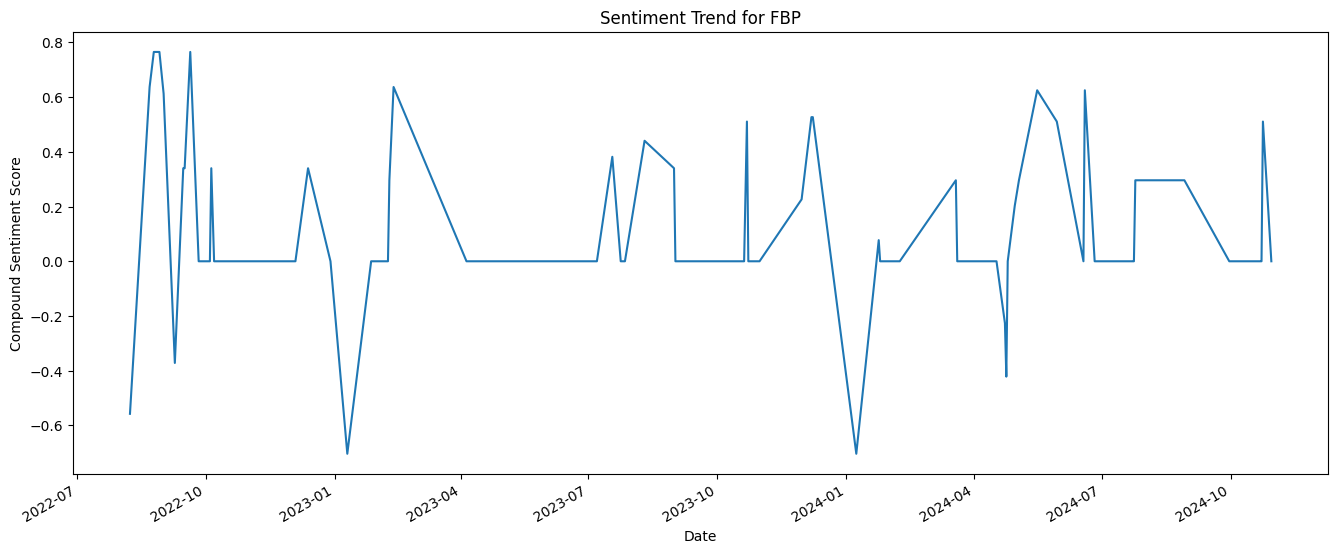

In [30]:
company_specific_sentiment_visualization('FBP')

In [31]:
FB_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('FBP', fb_stock)
FB_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,FBP,2022-08-08,-0.5574,13.868627
1,FBP,2022-08-22,0.6369,14.052561
2,FBP,2022-08-25,0.7650,14.146516
3,FBP,2022-08-29,0.7650,13.562485
4,FBP,2022-09-01,0.6124,13.136051


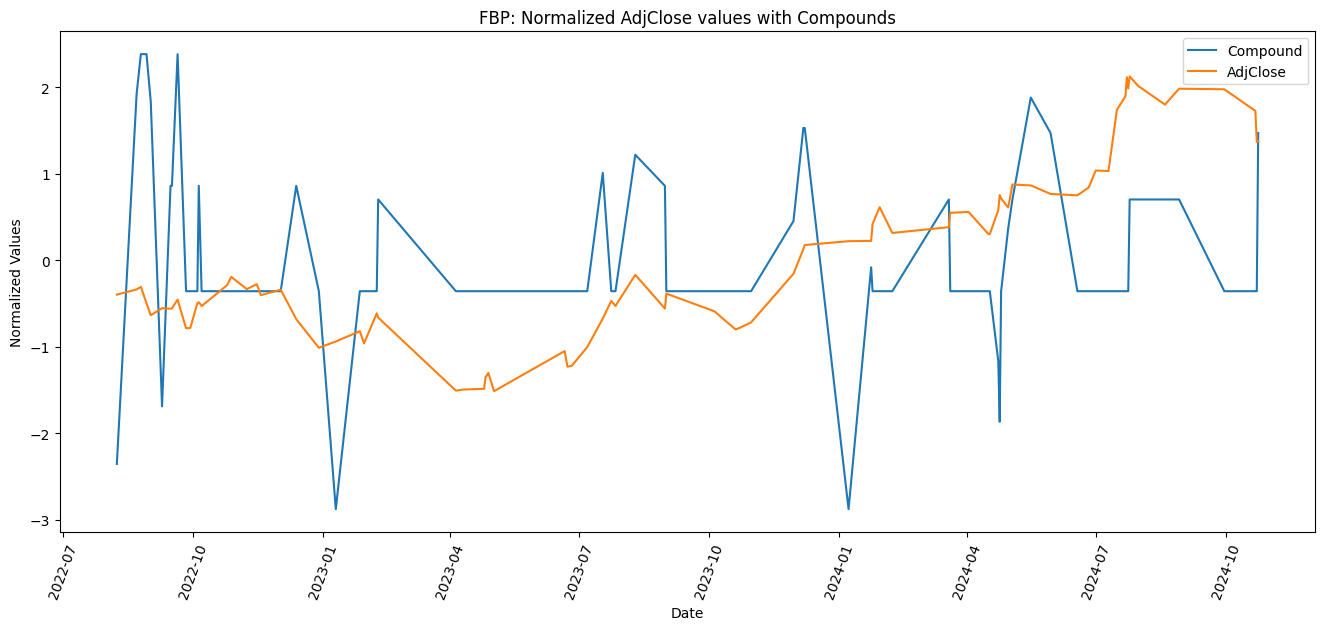

In [32]:
company_compound_adjclose_normalized('FBP', FB_combinated_dataframe)

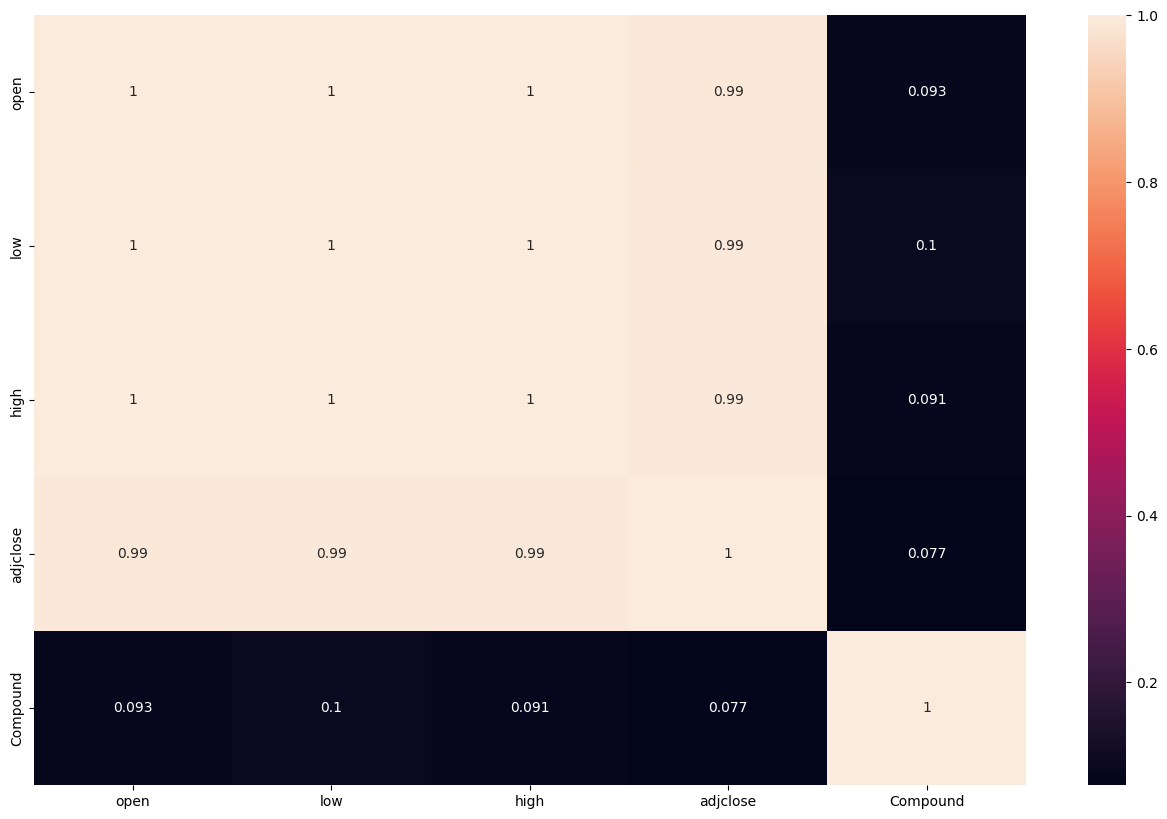

In [33]:
company_corr(fb_stock, FB_combinated_dataframe)

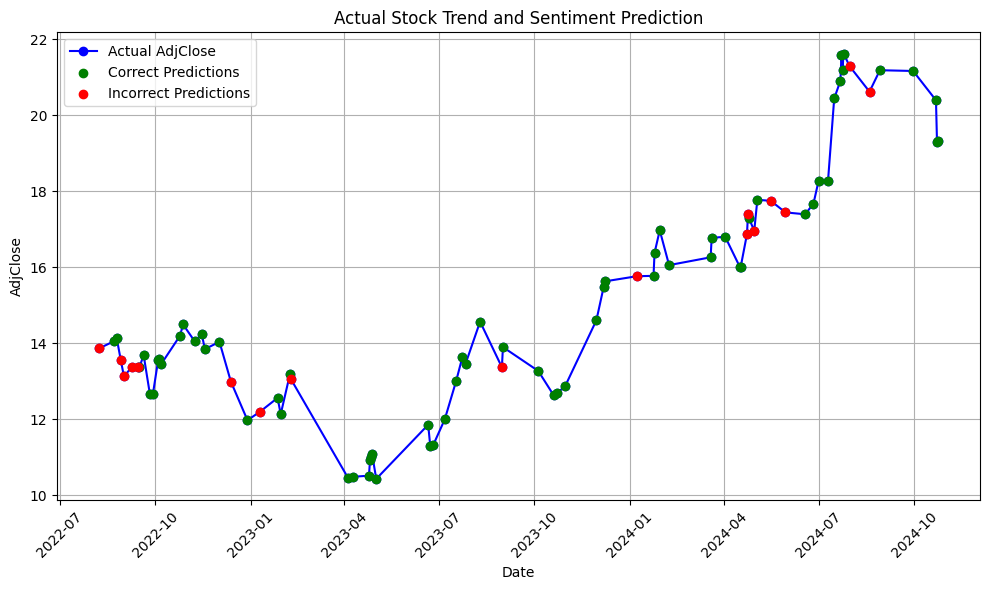

Accuracy of the predictions: 79.76%


In [34]:
def classify_sentiment(compound):
    if compound > 0.2:
        return 'Positive'
    elif compound < -0.2:
        return 'Negative'
    else:
        return 'Neutral'
def check_prediction(row):
    if row['Sentiment'] == 'Positive':
        return 'Correct' if row['PriceChange'] > 0 else 'Incorrect'
    elif row['Sentiment'] == 'Negative':
        return 'Correct' if row['PriceChange'] < 0 else 'Incorrect'
    else:
        return 'Correct'  # Neutral sentiment can go either way, so it's always correct
FB_combinated_dataframe['Sentiment'] = FB_combinated_dataframe['Compound'].apply(classify_sentiment)
FB_combinated_dataframe['PriceChange'] = FB_combinated_dataframe['adjclose'].pct_change() * 100

FB_combinated_dataframe['PredictionCorrect'] = FB_combinated_dataframe.apply(check_prediction, axis=1)
FB_combinated_dataframe.head()

accuracy = (FB_combinated_dataframe['PredictionCorrect'] == 'Correct').mean() * 100

# Step 4: Plot the graph for actual trend and prediction
plt.figure(figsize=(10, 6))

# Plot the actual AdjClose values
plt.plot(FB_combinated_dataframe['Date'], FB_combinated_dataframe['adjclose'], label='Actual AdjClose', marker='o', color='b')

# Plot the predicted trend (color points based on correctness)
correct_predictions = FB_combinated_dataframe[FB_combinated_dataframe['PredictionCorrect'] == 'Correct']
incorrect_predictions = FB_combinated_dataframe[FB_combinated_dataframe['PredictionCorrect'] == 'Incorrect']

plt.scatter(correct_predictions['Date'], correct_predictions['adjclose'], color='g', label='Correct Predictions', zorder=5)
plt.scatter(incorrect_predictions['Date'], incorrect_predictions['adjclose'], color='r', label='Incorrect Predictions', zorder=5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('AdjClose')
plt.title('Actual Stock Trend and Sentiment Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Display accuracy
print(f"Accuracy of the predictions: {accuracy:.2f}%")